In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import re
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhair\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bhair\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
df = pd.read_csv("data.csv")


In [11]:
print(df.head())
print(df.info())

                                              review             model  \
0  The movie was a complete snoozefest.  I regret...  Gemini-1.5-Flash   
1  Seriously, the worst venue I've ever been to. ...  Gemini-1.5-Flash   
2  This event was so poorly organized, it was a j...  Gemini-1.5-Flash   
3  What a disaster of a movie!  The acting was aw...  Gemini-1.5-Flash   
4  I wouldn't recommend this venue to my worst en...  Gemini-1.5-Flash   

  sentiment  
0  negative  
1  negative  
2  negative  
3  negative  
4  negative  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8236 entries, 0 to 8235
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     8236 non-null   object
 1   model      8234 non-null   object
 2   sentiment  8234 non-null   object
dtypes: object(3)
memory usage: 193.2+ KB
None


In [12]:
df = df[['review', 'sentiment']]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8236 entries, 0 to 8235
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     8236 non-null   object
 1   sentiment  8234 non-null   object
dtypes: object(2)
memory usage: 128.8+ KB
None


In [13]:
df = df.drop_duplicates(subset="review", keep="first")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5678 entries, 0 to 8235
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5678 non-null   object
 1   sentiment  5677 non-null   object
dtypes: object(2)
memory usage: 133.1+ KB
None


In [14]:
print("Final dataset shape:", df.shape)


Final dataset shape: (5678, 2)


In [15]:
df = df.dropna()
df = df.reset_index(drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5677 entries, 0 to 5676
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5677 non-null   object
 1   sentiment  5677 non-null   object
dtypes: object(2)
memory usage: 88.8+ KB
None


In [16]:
X = df["review"]
y = df["sentiment"]


In [17]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    
    # Tokenize
    words = text.split()
    
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return " ".join(words)


In [19]:
X_clean = X.apply(preprocess_text)
print("Before preprocessing:\n", X.iloc[0])
print("\nAfter preprocessing:\n", X_clean.iloc[0])


Before preprocessing:
 The movie was a complete snoozefest.  I regretted every second.  Total waste of money.

After preprocessing:
 movie complete snoozefest regretted every second total waste money


In [20]:

X_train, X_test, y_train, y_test = train_test_split(
    X_clean,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [30]:
tfidf = TfidfVectorizer(
    max_features=5000,      # limit feature size (safe + efficient)
    ngram_range=(1, 2)      # unigrams + bigrams
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


**Logistic Regression**

In [32]:

lr_model = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

**Navie Bayes**

In [34]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

**SVM**

In [36]:
svm_model = LinearSVC(
    C=1.0,
    random_state=42
)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

**Evaluation**

In [38]:
def evaluate_model(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="macro"),
        "Recall": recall_score(y_true, y_pred, average="macro"),
        "F1-Score": f1_score(y_true, y_pred, average="macro")
    }


In [39]:
evaluation_results = {
    "Logistic Regression": evaluate_model(y_test, y_pred_lr),
    "Naïve Bayes": evaluate_model(y_test, y_pred_nb),
    "Support Vector Machine": evaluate_model(y_test, y_pred_svm)
}


In [40]:
evaluation_df = pd.DataFrame(evaluation_results).T
evaluation_df

,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.868838,0.886693,0.840385,0.856934
Naïve Bayes,0.820423,0.867179,0.778405,0.803927
Support Vector Machine,0.892606,0.896280,0.875404,0.884250


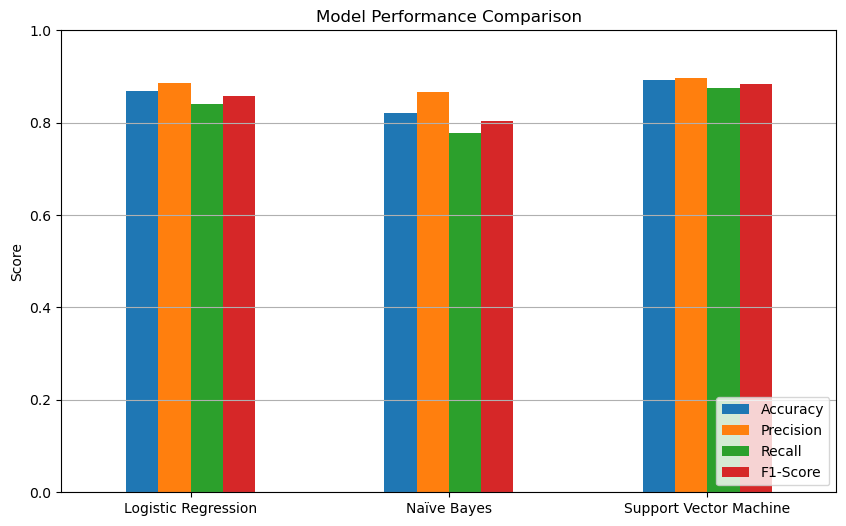

In [41]:
import matplotlib.pyplot as plt
evaluation_df.plot(
    kind="bar",
    figsize=(10, 6)
)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.grid(axis="y")
plt.show()


**Confussion matrix**

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [78]:
labels = ["positive", "neutral", "negative"]


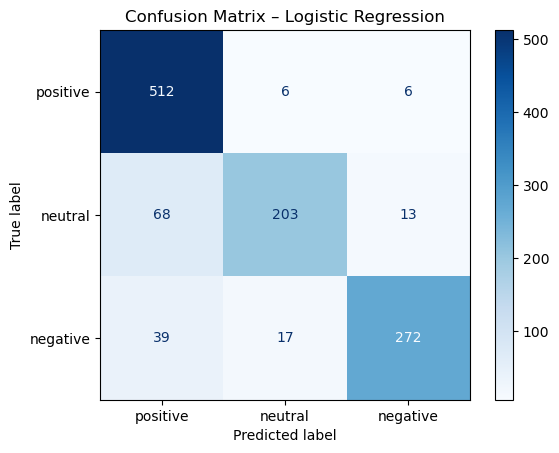

In [80]:
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=labels)

disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=labels
)

disp_lr.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


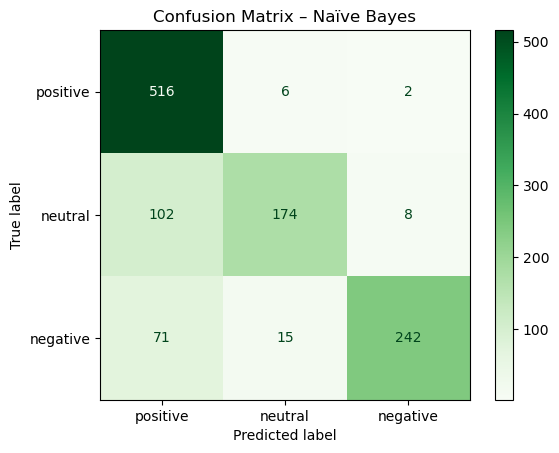

In [82]:
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=labels)

disp_nb = ConfusionMatrixDisplay(
    confusion_matrix=cm_nb,
    display_labels=labels
)

disp_nb.plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix – Naïve Bayes")
plt.show()


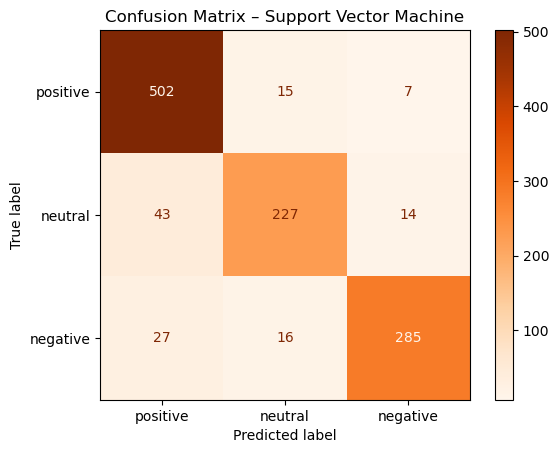

In [84]:
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)

disp_svm = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=labels
)

disp_svm.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix – Support Vector Machine")
plt.show()


**Testing**

In [61]:

def predict_sentiment_all_models(review_text):
    # Step 1: preprocess the review
    cleaned_review = preprocess_text(review_text)
    
    # Step 2: TF-IDF transform (NOT fit)
    review_tfidf = tfidf.transform([cleaned_review])
    
    # Step 3: predictions
    predictions = {
        "Logistic Regression": lr_model.predict(review_tfidf)[0],
        "Naïve Bayes": nb_model.predict(review_tfidf)[0],
        "Support Vector Machine": svm_model.predict(review_tfidf)[0]
    }
    
    return pd.DataFrame(
        predictions.items(),
        columns=["Algorithm", "Predicted Sentiment"]
    )


In [63]:
new_review = "The product quality is excellent and delivery was very fast."

predict_sentiment_all_models(new_review)


,Algorithm,Predicted Sentiment
0,Logistic Regression,positive
1,Naïve Bayes,positive
2,Support Vector Machine,positive


In [65]:
test_reviews = [
    "The product quality is excellent and delivery was very fast.",
    "The product is okay, nothing special.",
    "Very disappointing experience, waste of money.",
    "The product was waste of money."
]

for review in test_reviews:
    print(f"\nReview: {review}")
    print(predict_sentiment_all_models(review))



Review: The product quality is excellent and delivery was very fast.
                Algorithm Predicted Sentiment
0     Logistic Regression            positive
1             Naïve Bayes            positive
2  Support Vector Machine            positive

Review: The product is okay, nothing special.
                Algorithm Predicted Sentiment
0     Logistic Regression             neutral
1             Naïve Bayes             neutral
2  Support Vector Machine             neutral

Review: Very disappointing experience, waste of money.
                Algorithm Predicted Sentiment
0     Logistic Regression            negative
1             Naïve Bayes            negative
2  Support Vector Machine            negative

Review: The product was waste of money.
                Algorithm Predicted Sentiment
0     Logistic Regression            negative
1             Naïve Bayes            negative
2  Support Vector Machine            negative


In [67]:
import joblib
import os

os.makedirs("saved_models", exist_ok=True)
# Save TF-IDF vectorizer
joblib.dump(tfidf, "saved_models/tfidf_vectorizer.pkl")

# Save models
joblib.dump(lr_model, "saved_models/logistic_regression_model.pkl")
joblib.dump(nb_model, "saved_models/naive_bayes_model.pkl")
joblib.dump(svm_model, "saved_models/svm_model.pkl")
os.listdir("saved_models")


['logistic_regression_model.pkl',
 'naive_bayes_model.pkl',
 'svm_model.pkl',
 'tfidf_vectorizer.pkl']